Notebook to collect the information of the generation

### Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime

In [2]:
import signal

class TimeoutError(Exception):
    pass

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

# with timeout(seconds=1):
#     try:
#         time.sleep(2)
#     except TimeoutError:
#         print 'Got it'

In [3]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from progressBar import ProgressBar

In [4]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

Welcome to JupyROOT 6.12/07


In [5]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis
from DataFormats.FWLite import Handle
# import commands

In [6]:
from analysis_utilities import DSetLoader

# Inputs

Max 3 dataset per time otherwise run out of memory

In [7]:
inDic = {}

In [8]:
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0')
inDic['mu_20'] = DSetLoader('B0_MuNuDmst_PU20')
# inDic['mu_35'] = DSetLoader('B0_MuNuDmst_PU35')
# inDic['muHQET_0'] = DSetLoader('B0_MuNuDmst_HQETcentral_PU0')

inDic['tau'] = DSetLoader('B0_TauNuDmst_PU20')
inDic['Hc'] = DSetLoader('B0_DmstHc_PU20')
inDic['Dstst'] = DSetLoader('Bp_MuNuDstst_PU20')

CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.


In [9]:
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0', candDir='ntuples_probeB2DstMu')
# inDic['p_mu_c0'] = DSetLoader('p_B0_MuNuDst_PUc0', candDir='ntuples_probeB2DstMu')
# inDic['p_tau_c0'] = DSetLoader('p_B0_TauNuDst_PUc0', candDir='ntuples_probeB2DstMu')

In [10]:
# inDic['JPsiKst_0'] = DSetLoader('B0_JpsiKst_PU0', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_20'] = DSetLoader('B0_JpsiKst_PU20', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_35'] = DSetLoader('B0_JpsiKst_PU35', candDir='ntuples_B2JpsiKst')

# inDic['JPsiKstFSR_20'] = DSetLoader('B0_JpsiKstFSR_PU20', candDir='ntuples_B2JpsiKst')

# Efficiency

In [11]:
def getEff(k,N):
    e = k/float(N)
    de = np.sqrt(e*(1-e)/N)
    return [e, de]

## Generator Efficiency

In [12]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'SIM')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'SIM')]

In [13]:
def analyzeMINIAODs(fileList):  
    print 'Analizing', len(fileList), 'MINIAOD'
    N_gen = 0
    N_cuts = 0
    xsec = []
    xsec_err = []
    pb = ProgressBar(maxEntry=len(fileList))
    skippedFiles = []
    for i_j, fileName in enumerate(fileList):
        pb.show(i_j)
        with timeout(seconds=1):
            try:
#                 cmd = 'python generatorEfficiency_MINIAODSIM.py ' + fileName
#                 status, output = commands.getstatusoutput(cmd)
#                 aux = output.split(' ')
#                 N_gen += float(aux[0])
#                 N_cuts += float(aux[1])
#                 xsec.append(float(aux[2]))
#                 xsec_err.append(float(aux[4]))
                for lumi in Lumis(fileName):
                    prods = {}
                    for k,v in handle.iteritems():
                        lumi.getByLabel(v[1], v[0])
                        prods[k] = v[0].product()
                    N_cuts += prods['genFilter'].numEventsPassed()
                    N_gen += prods['genFilter'].numEventsTotal()
                    xs = prods['genProduct'].getProcessInfos()[0].lheXSec()
                    xsec.append(xs.value())
                    xsec_err.append(xs.error())
            except TimeoutError:
                skippedFiles.append(fileName)
    print 'Skipped {} files'.format(len(skippedFiles))
    print 'Total events in analyzed MINIAODs', N_cuts
    xsec = np.array(xsec)
    xsec_err = np.array(xsec_err)
    return N_gen, N_cuts, xsec, xsec_err

In [14]:
N_max = 1000
recreate = []#inDic.keys()
for n, d in inDic.iteritems():
    print '\n\n--> ' + d.sample
    
    outdir = os.path.join(d.candLoc, d.full_name)
    outyamlFile = os.path.join(outdir,'effMCgenerator.yaml')
    if os.path.isfile(outyamlFile) and not n in recreate:
        print 'Already present'
        dic = yaml.load(open(outyamlFile, 'r'))
        print dic
        continue
        
    fileList = []
    for directory in d.MINIAOD_dirs:
        fileList += glob(directory + '/out_MINIAODSIM_*.root')
    if N_max > 0 and N_max < len(fileList):
        fileList = np.random.choice(fileList, N_max)
    
    N_gen, N_cuts, xsec, xsec_err = analyzeMINIAODs(fileList)
    s2 = np.square(xsec_err)
    num = np.sum(xsec/s2)
    den = np.sum(1./s2)
    xsec = 1e3*num/den
    xsec_err = 1e3*np.sqrt(1/den)
    print 'Xsec: {:1.4e} +/- {:1.4e} fb ({:1.1e})'.format(xsec, xsec_err, xsec_err/xsec)
    d.xsec = [xsec, xsec_err]
    
    e, de = getEff(N_cuts, N_gen)
    print 'eff generator: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    d.effGEN = [e, de]

    dump_dic = {}
    for k in ['xsec', 'effGEN']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(outyamlFile, 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bp_MuNuDstst_PU20
Already present
{'xsec': [148772562432.68887, 7189916.856748202], 'effGEN': [0.004891204942234108, 6.995476600788558e-06]}


--> B0_TauNuDmst_PU20
Already present
{'xsec': [148780358588.90646, 7172565.643644872], 'effGEN': [0.0013360287382761407, 3.6538362202769994e-06]}


--> B0_MuNuDmst_PU20
Already present
{'xsec': [148782163489.2487, 4064905.3487632805], 'effGEN': [0.007007189803588201, 4.72861991039584e-06]}


--> B0_DmstHc_PU20
Already present
{'xsec': [148781818576.86035, 4146031.22008329], 'effGEN': [0.0005071146773654296, 1.3017714341741907e-06]}


## ntuplizer efficiency

In [15]:
for d in inDic.values():
    print '\n\n--> ' + d.sample

    if not os.path.isdir(d.ntuples_dir):
        continue
    cand_out_list = glob(os.path.join(d.ntuples_dir,'out/job*.out'))
    N_analyzed = 0
    N_trg = 0
    N_cand = 0
    print 'Analyzing {} ntuplizer job logs'.format(len(cand_out_list))
    pb = ProgressBar(maxEntry=len(cand_out_list))
    for ic, cand_out in enumerate(cand_out_list):
        pb.show(ic)
        eff_ln = []
        counters = []
        takingCounters = False
        for line in open(cand_out).readlines():
            if 'efficiency:' in line:
                eff_ln.append(line)
            elif 'counters:' in line:
                    takingCounters = True
            elif takingCounters and line[:-1].isdigit():
                counters.append(int(line[:-1]))
            elif takingCounters:
                takingCounters = False

        aux = re.search('[0-9]+/[0-9]+', eff_ln[0]).group(0)
        aux = aux.split('/')
        N_analyzed += int(aux[1])
        N_trg += int(aux[0])
        
        aux = re.search(': [0-9]+/', eff_ln[1]).group(0)
        N_cand += int(aux[2:-1])
        
        counters=np.array(counters)
        if not hasattr(d, 'counters'):
            d.counters = counters
        else:
            d.counters += counters
        
    d.nTotMINIAOD = N_analyzed
    d.nTotCAND = N_cand
    print 'Total MINIAOD:', N_analyzed
    print 'Total candidates:', N_cand
    
    e, de = getEff(N_trg, N_analyzed)
    d.effCAND_trg = e, de
    print 'eff candidates (trigger): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    e, de = getEff(N_cand, N_trg)
    d.effCAND_cand = e, de
    print 'eff candidates (cand): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    e, de = getEff(N_cand, N_analyzed)
    d.effCAND = e, de
    print 'eff candidates: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    print 'Getting the total rates (if existing)'
    try:
        fCandLoc = glob(os.path.join(d.ntuples_dir,'out_CAND_*.root'))[0]
        fCand = ur.open(fCandLoc)
        Trate = fCand['p']['Trate']
        d.rate = {}
        for k in Trate.keys():
            r = Trate.array(k)[0]
            r *= 1e12 #GeV -> meV
            d.rate[str(k)] = r
        print 'Done'
    except:
        print 'Not found'
    
    dump_dic = {'nTotMINIAOD': int(d.nTotMINIAOD), 'nTotCAND': int(d.nTotCAND)}
    for k in ['effCAND', 'effCAND_trg', 'effCAND_cand']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if hasattr(d, 'rate'):
        for k, v in d.rate.iteritems():
            dump_dic['rate_'+k] = float(v)
    with open(os.path.join(d.ntuples_dir,'effCAND.yaml'), 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bp_MuNuDstst_PU20
Analyzing 386 ntuplizer job logs
[####################]  100% - Tot. time: 6.4 s
Total MINIAOD: 8700861
Total candidates: 199562
eff candidates (trigger): 2.010e-01 +/- 1.359e-04 (6.8e-04)
eff candidates (cand): 1.141e-01 +/- 2.404e-04 (2.1e-03)
eff candidates: 2.294e-02 +/- 5.075e-05 (2.2e-03)
Getting the total rates (if existing)
Done


--> B0_TauNuDmst_PU20
Analyzing 894 ntuplizer job logs
[####################]  100% - Tot. time: 14.7 s
Total MINIAOD: 5825628
Total candidates: 167393
eff candidates (trigger): 2.670e-01 +/- 1.833e-04 (6.9e-04)
eff candidates (cand): 1.076e-01 +/- 2.485e-04 (2.3e-03)
eff candidates: 2.873e-02 +/- 6.921e-05 (2.4e-03)
Getting the total rates (if existing)
Done


--> B0_MuNuDmst_PU20
Analyzing 1339 ntuplizer job logs
[####################]  100% - Tot. time: 23.5 s
Total MINIAOD: 65047704
Total candidates: 1484198
eff candidates (trigger): 2.406e-01 +/- 5.300e-05 (2.2e-04)
eff candidates (cand): 9.483e-02 +/- 7.406e-05 (7.8e-04)


+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+
| Sample |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |  9   |  10  |  11  |  12  |
+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+
| Dstst  | 20.10 | 19.28 | 19.13 | 18.62 | 17.68 | 15.45 | 10.72 | 10.68 |  9.07 | 4.87 | 2.53 | 2.29 | 2.29 |
|  tau   | 26.70 | 25.72 | 25.50 | 24.24 | 23.12 | 19.49 | 14.42 | 14.38 | 12.25 | 6.76 | 3.58 | 2.87 | 2.87 |
| mu_20  | 24.06 | 23.04 | 22.87 | 21.61 | 20.41 | 16.74 | 12.16 | 12.13 | 10.14 | 5.17 | 2.51 | 2.28 | 2.28 |
|   Hc   | 23.23 | 22.24 | 21.99 | 21.10 | 20.51 | 18.10 | 11.65 | 11.59 | 10.81 | 7.46 | 4.39 | 2.94 | 2.94 |
+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+


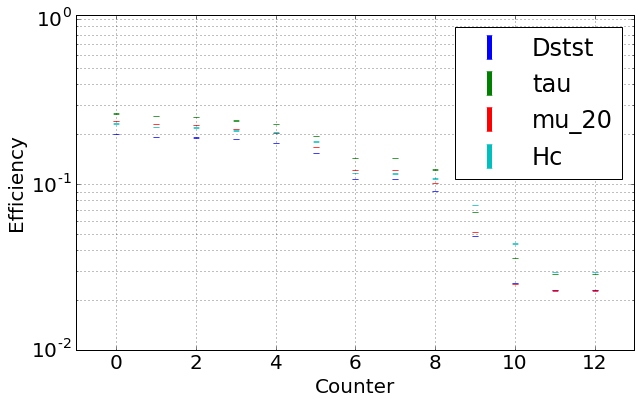

In [16]:
t = PrettyTable()
t.field_names = ['Sample'] + [str(i) for i in range(d.counters.shape[0])]
for n, d in inDic.iteritems():
    eff = np.zeros((d.counters.shape[0], 2))
    eff[0] = d.effCAND_trg
    for i in range(d.counters[1:].shape[0]):
        eff[i+1] = getEff(d.counters[i+1], d.nTotMINIAOD)
    t.add_row([n] + ['{:.2f}'.format(100*e[0]) for e in eff])
    x = np.arange(eff.shape[0])
    p = plt.errorbar(x, eff[:, 0], eff[:,1], lw=0, elinewidth=5, label=n)
    
#     plt.plot(x[[0,-1]], 2*[d.effCAND[0]], '-', color=p[0].get_color())
#     plt.fill_between(x[[0,-1]], 2*[d.effCAND[0]-d.effCAND[1]], 2*[d.effCAND[0]+d.effCAND[1]], color=p[0].get_color(), alpha=0.2)
print t
plt.rcParams.update({'font.size': 20})
plt.xlabel('Counter')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.ylim(0.01,1.05)
plt.xlim(-1, eff.shape[0])
plt.grid(True, which='both')
plt.yscale('log')
plt.gcf().set_size_inches(10, 6)